<a href="https://colab.research.google.com/github/MrOnie/DeepLearning/blob/master/Laboratorio1_CNN_Grupo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio: Convolutional Neural Networks

Integrantes:
- Ronie Martínez
- Jorge Mendoza
- Juan Pablo Muñoz

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [0]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob
import keras
import tensorflow as tf

# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

Using TensorFlow backend.


10665984/10658925 [==============================] - 0s 0us/step


In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [0]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [0]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


### Funciones para graficar resultados de Accuracy y Loss

In [0]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

### Función para presentar de manera gráfica el resultado de una predicción. 

Tomada de (https://www.tensorflow.org/tutorials/keras/classification) y editada para adaptarla.

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0])

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
    plt.xlabel("{} {:2.0f}%".format(MAP_CHARACTERS[predicted_label],
                                100*np.max(predictions_array)),
                                color=color)
  else:
    color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(MAP_CHARACTERS[predicted_label],
                                100*np.max(predictions_array),
                                MAP_CHARACTERS[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label, nombres=False):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  if nombres:
    plt.xticks(range(18), MAP_CHARACTERS.values(), rotation=90)
  else:
      plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(18), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

### Carga de los datos

In [0]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [0]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

### Normalización de los datos

In [0]:
# Normalización de los datos
X = X / 255.0
X_t = X_t / 255.0
X.shape

(18992, 64, 64, 3)

### Visualización de ejemplos del train_set

In [0]:
#Función para visualizar ejemplos
def visualize_example(x,y):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.title(MAP_CHARACTERS[y])
    plt.show()

Train example X[ 991 ]


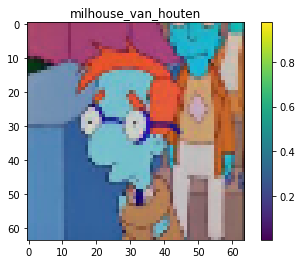

In [0]:
# 0<n<18991
n=np.random.randint(low=0, high=18991) #5000
print("Train example X[",n,"]")
visualize_example(X[n],y[n])

### Primera CNN

Inicialmente se probaron varias topologías de CNN modificando capas, diferentes tamaños de filtros, padding, y combinándolas con capas de MaxPooling y Dropout (igualmente, modificando sus valores).

La CNN presentada a continuación presenta una accuracy alrededor del 90% para el train_set y 88% de accuracy en el validation_set:

#### Características de la primera CNN propuesta con resultados buenos.

Capas:
* Entrada de dimensión (64, 64, 3).
* Cuatro convolutional layers de tamaños: 32, 64, 128 y 256. Filtros de tamaño (3,3). Función de activación utilizada: ReLU. Padding: 'same' para mantener el tamaño original.
* Dos maxpooling (2,2) + dropout (0.5) layers después de cada dos convolutional layers.
* Dos Fully Connected layers de 256 y 128 nodos respectivamente + dropout layers (0.5) después de cada una.
* Layer de salida con 18 nodos. Función de activación: Softmax.

Optimizador:
* Adam con sus parámetros por defecto.

Entrenamiento:
* Epochs: 50 (máximo. EarlySropping definida y usada).
* Batch_size: 128.
* Validation_set: 20%

#### Entrenamiento

In [0]:
model = tf.keras.Sequential([
    # Se define la primera capa oculta junto con la información de la capa de entrada
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(64,64,3)),
    #Al utilizar como opción padding "same", se logra que la salida tenga el mismo tamaño 
    #que la entrada, por lo que nos queda una capa de dimensiones (64,64,32)
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    #Al igual que el anterior, para este caso se tendría una capa de dimensiones
    #(64,64,64)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #H2=𝑊2=(𝑊1−𝐹)/𝑆+1---> H2=W2=(64-2)/2+1
    #Tenemos una capa de dimensiones (32,32,64)
     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    #La capa en este punto tiene dimensiones: (32,32,128)
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    #La capa en este punto tiene dimensiones: (32,32,256)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Al aplicar la fórmula previa para Max Pooling, Tenemos una capa de 
    #dimensiones (16,16,64)
    tf.keras.layers.Dropout(0.5),
    # Se utiliza una capa Flatten con el fin de que las neuronas se ordenen para
    # poder luego tener una red interconectada normal
    tf.keras.layers.Flatten(),
    # Dense FC
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    # Se define la capa de salida
    tf.keras.layers.Dense(18, activation=tf.nn.softmax)   # 18-node softmax layer in %
])

model.summary()

#Definición del optimizador, función de pérdida y métrica de evaluación
#optimizer = tf.keras.optimizers.RMSprop(0.001)
#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
#optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
)

#Entrenamiento del modelo (train set) con epochs y batch size
monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, 
                                           verbose=1, mode='auto', baseline=None, restore_best_weights=True)
history = model.fit(X, y,
                    epochs=50,
                    batch_size=128, #32, 128, 256
                    validation_split=0.2,     #Validation set 20%
                    callbacks=[monitor]
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________

#### Resultados

Los resultados del train_set y validation_set son bastante similares por lo que estamos evitando el overfitting.

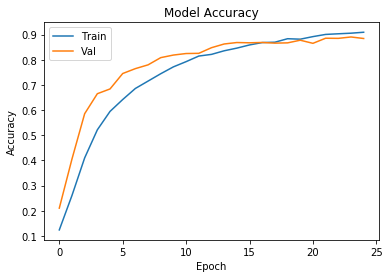

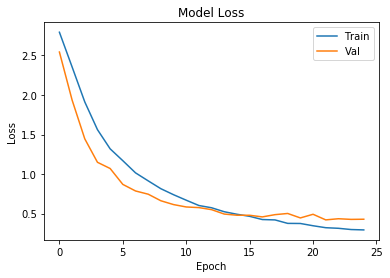

In [0]:
plot_acc(history)
plot_loss(history)

#### Evaluación

In [0]:
# Evaluación del modelo con el test_set
score = model.evaluate(X_t, y_t)

890/890 [==============================] - 1s 995us/sample - loss: 0.1855 - acc: 0.9517


La accuracy en el test_set vemos que es bastante buena: alrededor del 96%. Superando el desempeño esperado en función del train_set y validation_set.

In [0]:
predictions = model.predict(X_t)
predictions.shape

(890, 18)

Test set X_t[ 787 ]


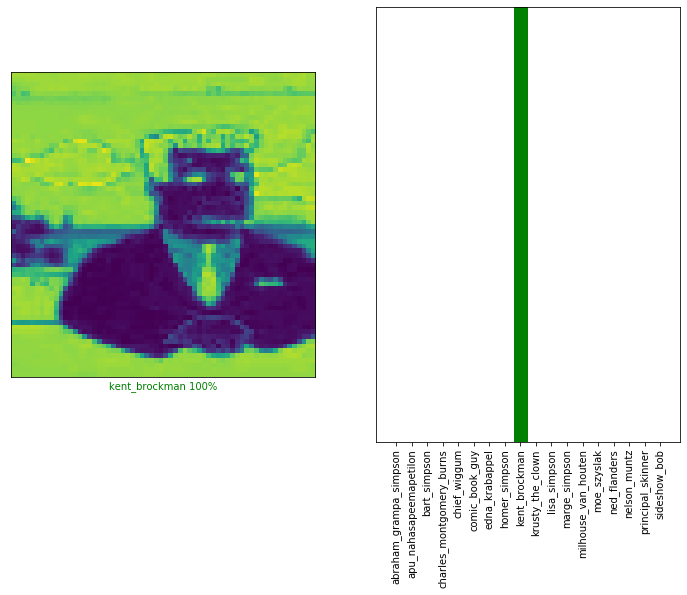

In [0]:
# 0<i<889
n_t = np.random.randint(low=0, high=889) #100
print("Test set X_t[",n_t,"]")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(n_t, predictions, y_t, X_t)
plt.subplot(1,2,2)
plot_value_array(n_t, predictions, y_t, nombres=True)

#### Resultados visuales y evaluación del desempeño del modelo

Se presenta una matriz con varias imágenes y sus respectivos resultados con su porcentaje de predicción. 


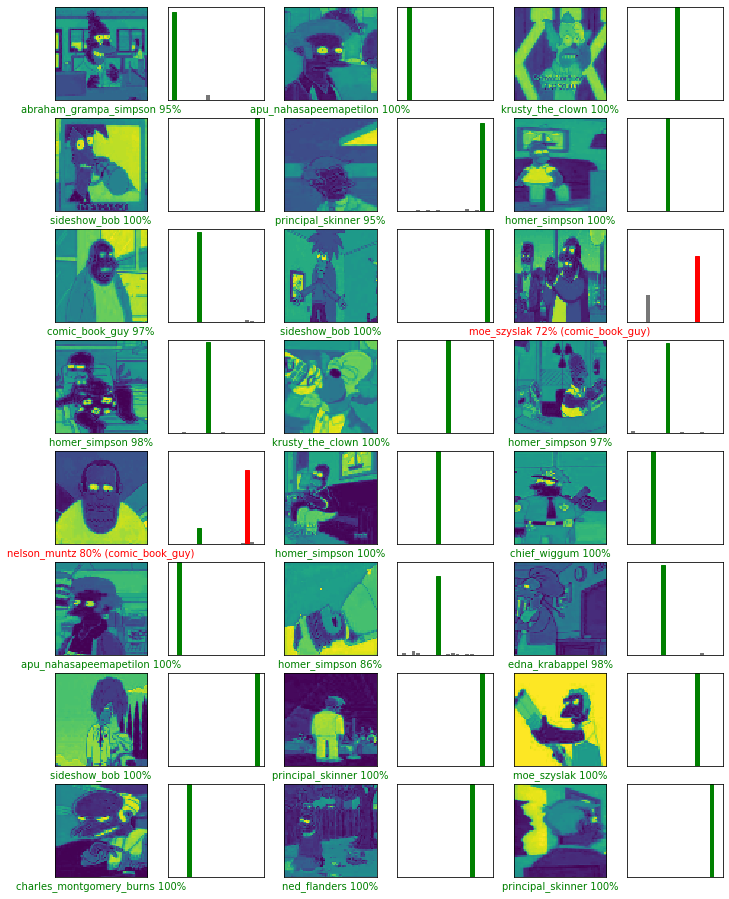

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in green, incorrect predictions in red
num_rows = 8
num_cols = 3
num_images = num_rows*num_cols
index = np.random.randint(low=0, high=889-24)

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+index, predictions, y_t, X_t)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+index, predictions, y_t)

### Mejor CNN

#### Características de la CNN propuesta con mejor desempeño que las anteriores.

En la teoría se comentó que para problemas con imágenes es mejor tener capas convolucionales y de maxpooling, en comparación que capas fully-connected, lo cual se comprobó en la practica. Adicionalmente, la reducción de parámetros al eliminar una FC layer es muy significativa, traducida en ahorro de coste computacional.

Capas:
* Entrada de dimensión (64, 64, 3).
* Cuatro convolutional layers de tamaños: 32, 64, 128 y 256. Filtros de tamaño (3,3). Función de activación utilizada: ReLU. Padding: 'same' para mantener el tamaño original. Maxpooling layers (2,2) después de cada Convolutional layer.
* Dos dropout (0.5) layers después de cada dos convolutional + maxpooling layers.
* Una Fully Connected layer de 128 nodos + dropout layer (0.5).
* Layer de salida con 18 nodos. Función de activación: Softmax.

Optimizador:
* Adam con sus parámetros por defecto.

Entrenamiento:
* Epochs: 50 (máximo. EarlySropping definida y usada).
* Batch_size: 128.
* Validation_set: 20%

#### Entrenamiento

In [0]:
model2 = tf.keras.Sequential([
    # Se define la primera capa oculta junto con la información de la capa de entrada
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(64,64,3)),
    #Dimensiones de la red (64,64,32)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Dimensiones de la red (32,32,32)
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    #Dimensiones de la red (32,32,64)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Dimensiones de la red (16,16,64)
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    #Dimensiones de la red (16,16,128)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Dimensiones de la red (8,8,128)
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    #Dimensiones de la red (8,8,256)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Dimensiones de la red (4,4,256)
    tf.keras.layers.Dropout(0.5),
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    # Se define la capa de salida
    tf.keras.layers.Dense(18, activation=tf.nn.softmax)   # 18-node softmax layer in %
])

model2.summary()

model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
)

#Entrenamiento del modelo (train set) con epochs y batch size
monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, 
                                           verbose=1, mode='auto', baseline=None, restore_best_weights=True)
history2 = model2.fit(X, y,
                    epochs=50,
                    batch_size=128, #32, 128, 256
                    validation_split=0.2,     #Validation set 20%
                    callbacks=[monitor]
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 128)        

#### Resultados

Los resultados del train_set y validation_set son bastante similares por lo que estamos evitando el overfitting.

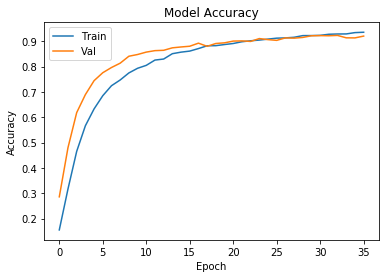

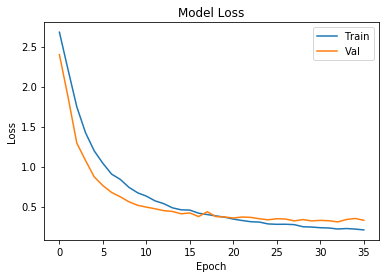

In [0]:
plot_acc(history2)
plot_loss(history2)

#### Evaluación

In [0]:
score2 = model2.evaluate(X_t, y_t)

890/890 [==============================] - 0s 462us/sample - loss: 0.1124 - acc: 0.9629


Aunque el desempeño de este modelo es mejor que el del modelo anterior (accuracy alrededor del 93% tanto para train_set como para validation_set), la accuracy en el test_set se mantiene similar: alrededor del 97%.

In [0]:
predictions2 = model2.predict(X_t)
y_pred2 = np.argmax(predictions2, axis=1)

#### Resultados visuales y evaluación del desempeño del modelo

Se presenta una matriz con varias imágenes y sus respectivos resultados con su porcentaje de predicción. 

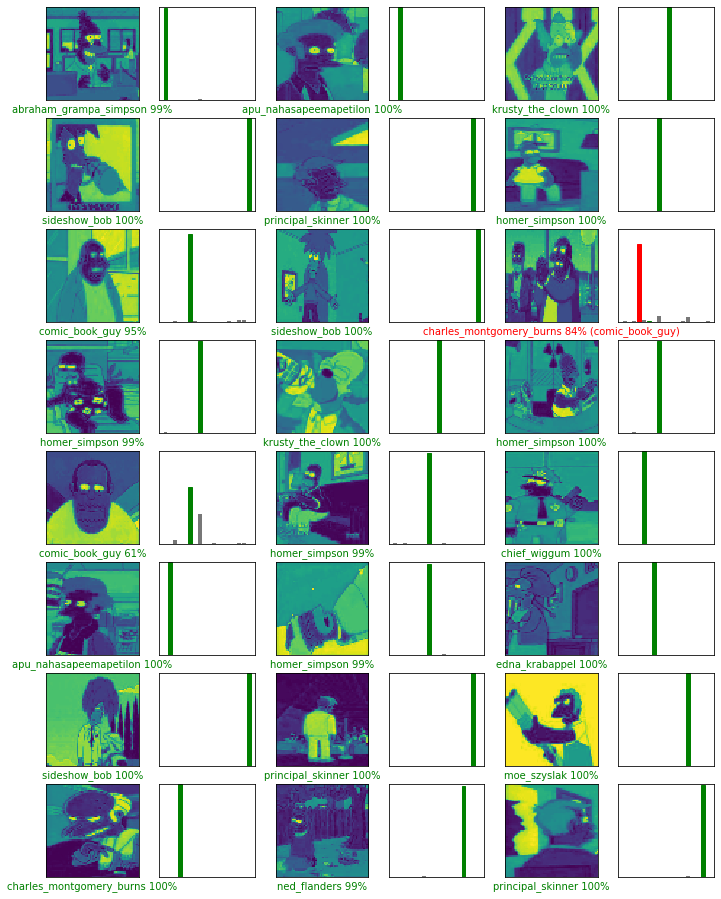

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in green, incorrect predictions in red
num_rows = 8
num_cols = 3
num_images = num_rows*num_cols
#index = np.random.randint(low=0, high=889-24)

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+index, predictions2, y_t, X_t)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+index, predictions2, y_t)

### Métricas de evaluación

Se presentan los resultados de precision, recall y f1-score por clase.

In [0]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
print(classification_report(y_t, y_pred2, digits=3))

#MAP_CHARACTERS = {
#    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
#    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
#    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
#    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
#    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
#}

              precision    recall  f1-score   support

           0      1.000     0.854     0.921        48
           1      0.980     1.000     0.990        50
           2      0.925     0.980     0.951        50
           3      0.920     0.958     0.939        48
           4      0.960     0.960     0.960        50
           5      0.958     0.939     0.948        49
           6      0.979     0.920     0.948        50
           7      0.891     0.980     0.933        50
           8      0.980     0.980     0.980        50
           9      0.980     1.000     0.990        50
          10      0.958     0.920     0.939        50
          11      1.000     1.000     1.000        50
          12      0.980     0.980     0.980        49
          13      0.960     0.960     0.960        50
          14      0.961     1.000     0.980        49
          15      1.000     0.920     0.958        50
          16      0.943     1.000     0.971        50
          17      0.979    

Las clases con más bajo desempeño son:
* 0: abraham_grampa_simpson
* 7: homer_simpson
* 10: lisa_simpson

Mientras que las clases con mejor desempeño son:
* 11: marge_simpson
* 9: krusty_the_clown
* 1: apu_nahasapeemapetilon

In [0]:
print("Confusion Matrix")
confusion_matrix(y_t, y_pred2)

Confusion Matrix


array([[43,  0,  0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  1,  1,
         0,  0],
       [ 0, 49,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0],
       [ 0,  0,  0, 46,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0, 49,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0],
       [ 0,  0,  0,  1,  0, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0],
       [ 0,  0,  0,  1,  0,  0, 47,  0,  0,  0,  0,  0,  0,  0,  2,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  4,  1,  0,  0,  0,  0,  0,  0, 45,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  

### Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

En esta fase se realiza la implementación del Data Aumentation para el cual usaremos **ImageDataGenerator** de Keras.

La clase ImageDataGenerator contiene varios parámetros que son necesario conocer debido a que cada uno de ello puede influir a la hora de transformar la data y en el entrenamiento.

Para este caso se realizaron las siguientes moficiaciones en la data:


*   **vertical_flip=False :** No giramos aleatoriamente las imágenes verticalmente.
*   **horizontal_flip=True :** Giramos aleatoriamente las imágenes horizontalmente.
*   **rotation_range=1 :** Rotamos la imagen aleatoriamente



In [0]:
datagen = ImageDataGenerator(vertical_flip=False, horizontal_flip=True, rotation_range=1)

El método flow lo que realiza es generar la data de las imágenes respetando lo parametrizado en la clase ImageDataGenerator.

In [0]:
it = datagen.flow(X, y)

#### Entrenamiento

In [0]:
modelAD = tf.keras.Sequential([
    # Se define la primera capa oculta junto con la información de la capa de entrada
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(64,64,3)),
    #Dimensiones de la capa (64,64,32)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Dimensiones de la capa (32,32,32)
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    #Dimensiones de la capa (32,32,64)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Dimensiones de la capa (16,16,64)
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    #Dimensiones de la capa (16,16,128)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Dimensiones de la capa (8,8,128)
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    #Dimensiones de la capa (8,8,256)
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    #Dimensiones de la capa (4,4,256)
    tf.keras.layers.Dropout(0.5),
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    # Se define la capa de salida
    tf.keras.layers.Dense(18, activation=tf.nn.softmax)   # 18-node softmax layer in %
])

modelAD.summary()

#Definición del optimizador, función de pérdida y métrica de evaluación
#optimizer = tf.keras.optimizers.RMSprop(0.001)
#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
#optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
modelAD.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
)

#Entrenamiento del modelo (train set) con epochs y batch size
monitorAD = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=7, 
                                           verbose=1, mode='auto', baseline=None, restore_best_weights=True)
historyAD = modelAD.fit_generator(it, steps_per_epoch=313, 
                                  epochs=50)#, callbacks=[monitor])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 128)        

#### Evaluación

In [0]:
scoreAD = modelAD.evaluate(X_t, y_t)

890/890 [==============================] - 0s 395us/sample - loss: 0.1703 - acc: 0.9461


In [0]:
predictionsAD = modelAD.predict(X_t)
y_predAD = np.argmax(predictionsAD, axis=1)

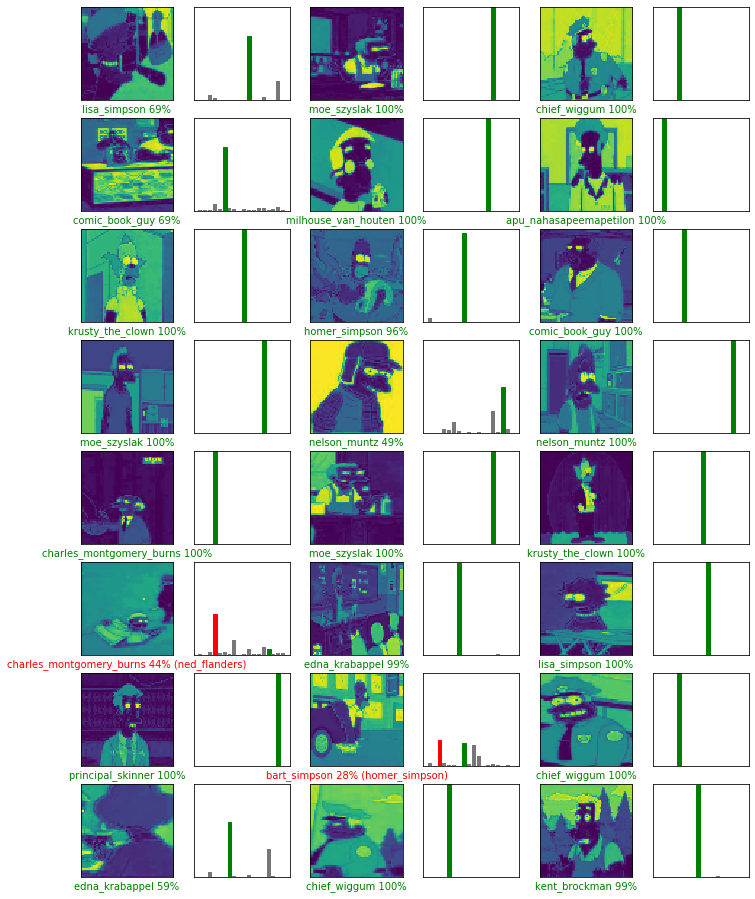

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 8
num_cols = 3
num_images = num_rows*num_cols
index = np.random.randint(low=0, high=889-24)

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+index, predictionsAD, y_t, X_t)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+index, predictionsAD, y_t)

### Conclusiones
* Se presentaron dos modelos de CNN con resultados bastante buenos: ambas sobre el 90% de accuracy en el entrenamiento y sobre el 96% de accuracy en el test_set propuesto.
* Se utilizaron los parámetros de padding y tamaños de filtros en las capas de las topologías propuestas, verificando su funcionamiento y utilidad en este tipo de redes neuronales.
* Se hizo uso de diversas estrategias para evitar el overfitting, entre ellas: capas de dropout, función de early stopping y uso de validation_set. Obteniendo como resultados similares tanto en el train_set y en el validation_set, además de resultados incluso mejores en el test_set.
* Se comprobó que las Fully-connected layers no son especialmente adecuadas para este tipo de problemas (imágenes), y que debido a la cantidad de features de entrada (píxeles) los parámetros son extremadamente grandes. Es por esto que las Convolutional layer han tenido gran acogida en este campo, demostrando un desempeño muy bueno y con una cantidad de parámetros reducida.
* Hay que tener especial cuidado en los parámetros que se utilizan en al programar DataAugmentation, ya que si unos parámetros se establecen muy altos, es probable que las imágenes que se obtienen como resultado, sean poco reconocibles, por ejemplo al momento de ajustar el brillo, si se ajustan parámetros extremos, habrán imágenes que sean totalmente negras o blancas, arruinando así el entrenamiento de una red y reduciendo considerablemente el resultado y la precisión. Por ello, en este caso, se utilizó una serie de parámetros que no alteraron de manera extrema las imágenes